In [5]:
#Ensure dependencies are compatible versions
!pip uninstall keras-nightly
!pip uninstall -y tensorflow

%tensorflow_version 1.x
!pip install tensorflow-gpu==1.14.0

!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1
!pip install keras==2.1.6
!pip install h5py==2.10.0
!pip install imgaug
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()

Found existing installation: tensorflow 1.15.2
Uninstalling tensorflow-1.15.2:
  Successfully uninstalled tensorflow-1.15.2
  Using cached tensorboard-1.14.0-py3-none-any.whl (3.1 MB)
  Using cached tensorflow_estimator-1.14.0-py2.py3-none-any.whl (488 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0


--2021-09-25 21:02:32--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.20.126
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.20.126|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb [following]
--2021-09-25 21:02:32--  https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64.deb?DGZQSjrTJV0AsZuXoUOjHsjGTlKnOddCHPb3P3Q8GNPYDyUcL7JS4MaMgMR4taSovE3M9bQlCIi0nYf5Ln-p_TH3IaKmW

'/device:GPU:0'

In [2]:
#Mount drive containing images and annotations via Google Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!ls
%cd gdrive/My Drive/Rooftop_detection

Mounted at /content/gdrive
cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb  gdrive  sample_data
/content/gdrive/My Drive/Rooftop_detection


In [3]:
#Navigate to Mask_RCNN folder and run setup
%cd Mask_RCNN
! python setup.py install

/content/gdrive/My Drive/Rooftop_detection/Mask_RCNN
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt


In [6]:
import os
import shutil
import pickle
import sys
import itertools
import math
import logging
import json
import re
import random
import imgaug
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log, load_image_gt, mold_image

from rooftops import *

%matplotlib inline 

In [7]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "model/logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "model/mask_rcnn_coco.h5")

DATASET_DIR = os.path.join(ROOT_DIR, "data/maps")

### Loading `train_set`

In [8]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
train_set = RooftopDataset()
train_set.load_dataset(DATASET_DIR, "train")

# Must call before using the dataset
train_set.prepare()

print("Image Count: {}".format(len(train_set.image_ids)))
print("Polygon Count: {}".format(train_set.num_polygons))
print("Class Count: {}".format(train_set.num_classes))
for i, info in enumerate(train_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 69
Polygon Count: 1488
Class Count: 4
  0. BG                                                
  1. roof                                              
  2. pool                                              
  3. sports                                            


### Loading `val_set`

In [9]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
val_set = RooftopDataset()
val_set.load_dataset(DATASET_DIR, "val")

# Must call before using the dataset
val_set.prepare()

print("Image Count: {}".format(len(val_set.image_ids)))
print("Polygon Count: {}".format(val_set.num_polygons))
print("Class Count: {}".format(val_set.num_classes))
for i, info in enumerate(val_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 22
Polygon Count: 545
Class Count: 4
  0. BG                                                
  1. roof                                              
  2. pool                                              
  3. sports                                            


## Model training epochs 1-10

In [10]:
# define a configuration for the model to train
class roofHyperConfig(Config):
    # Give the configuration a recognizable name
    NAME = "roof_hyper"
    # Number of classes (background + roof + pool + sports
    NUM_CLASSES = 1 + 3
    # Number of training steps per epoch
    STEPS_PER_EPOCH = len(train_set.image_ids)
    # Weights for the sum of losses
    LOSS_WEIGHTS = {
        'rpn_class_loss': 1.0,
        'rpn_bbox_loss': 0.8,
        'mrcnn_class_loss': 6.0,
        'mrcnn_bbox_loss': 6.0,
        'mrcnn_mask_loss': 6.0
        }
    

 
# prepare config
config = roofHyperConfig()
config.display()

# define the model
model = modellib.MaskRCNN(mode='training', model_dir=MODEL_DIR, config=config)

# This augmentation applies 50% of the time, and when it does it flips images
# right/left half the time and adds a Gaussian blur with a random sigma
# in range 0 to 5.
augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
                ])


# load weights (mscoco)
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

epochs = 10

# Scale the magnitude of parameter updates during gradient descent
learning_rate = 0.001

# train weights (output layers or 'heads')
hyper_hist1 = model.train(train_set, val_set, learning_rate=learning_rate, epochs=epochs, augmentation=augmentation, layers='heads')


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 6.0, 'mrcnn_mask_loss': 6.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
68/69 [============================>.] - ETA: 3s - loss: 10.5057 - rpn_class_loss: 0.2900 - rpn_bbox_loss: 0.4507 - mrcnn_class_loss: 3.1904 - mrcnn_bbox_loss: 3.3626 - mrcnn_mask_loss: 3.2119

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


69/69 [==============================] - 408s 6s/step - loss: 10.4379 - rpn_class_loss: 0.2873 - rpn_bbox_loss: 0.4519 - mrcnn_class_loss: 3.1597 - mrcnn_bbox_loss: 3.3407 - mrcnn_mask_loss: 3.1983 - val_loss: 7.2277 - val_rpn_class_loss: 0.1435 - val_rpn_bbox_loss: 0.4615 - val_mrcnn_class_loss: 2.1505 - val_mrcnn_bbox_loss: 2.3229 - val_mrcnn_mask_loss: 2.1494

Epoch 2/10
69/69 [==============================] - 278s 4s/step - loss: 7.1056 - rpn_class_loss: 0.1554 - rpn_bbox_loss: 0.5253 - mrcnn_class_loss: 2.1639 - mrcnn_bbox_loss: 2.0886 - mrcnn_mask_loss: 2.1725 - val_loss: 6.5292 - val_rpn_class_loss: 0.1160 - val_rpn_bbox_loss: 0.4399 - val_mrcnn_class_loss: 2.1697 - val_mrcnn_bbox_loss: 1.9535 - val_mrcnn_mask_loss: 1.8502
Epoch 3/10
69/69 [==============================] - 278s 4s/step - loss: 6.5412 - rpn_class_loss: 0.1295 - rpn_bbox_loss: 0.4719 - mrcnn_class_loss: 2.1217 - mrcnn_bbox_loss: 1.8200 - mrcnn_mask_loss: 1.9981 - val_loss: 6.3897 - val_rpn_class_loss: 0.1118 - v

In [12]:
with open('hyper_hist1.pickle', 'wb') as f:
    pickle.dump(hyper_hist1, f)

## Model training epochs 11-20

In [13]:
# Load the last model trained
weights_path = model.find_last()
model.load_weights(weights_path, by_name=True)

epochs = 20

# Scale the magnitude of parameter updates during gradient descent
learning_rate = 0.0005

# Train weights (output layers or 'heads')
hyper_hist2 = model.train(train_set, val_set, learning_rate=learning_rate, epochs=epochs, augmentation=augmentation, layers='heads')

Re-starting from epoch 10

Starting at epoch 10. LR=0.0005

Checkpoint Path: /content/gdrive/My Drive/Rooftop_detection/model/logs/roof_hyper20210925T1911/mask_rcnn_roof_hyper_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeD

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 11/20
68/69 [============================>.] - ETA: 2s - loss: 4.2222 - rpn_class_loss: 0.0859 - rpn_bbox_loss: 0.3520 - mrcnn_class_loss: 1.3350 - mrcnn_bbox_loss: 0.8859 - mrcnn_mask_loss: 1.5633

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


69/69 [==============================] - 386s 6s/step - loss: 4.2142 - rpn_class_loss: 0.0864 - rpn_bbox_loss: 0.3509 - mrcnn_class_loss: 1.3345 - mrcnn_bbox_loss: 0.8829 - mrcnn_mask_loss: 1.5595 - val_loss: 5.7009 - val_rpn_class_loss: 0.0878 - val_rpn_bbox_loss: 0.3070 - val_mrcnn_class_loss: 2.0939 - val_mrcnn_bbox_loss: 1.5849 - val_mrcnn_mask_loss: 1.6274
Epoch 12/20
69/69 [==============================] - 282s 4s/step - loss: 4.2580 - rpn_class_loss: 0.0897 - rpn_bbox_loss: 0.3461 - mrcnn_class_loss: 1.3471 - mrcnn_bbox_loss: 0.9167 - mrcnn_mask_loss: 1.5585 - val_loss: 5.6580 - val_rpn_class_loss: 0.0840 - val_rpn_bbox_loss: 0.3194 - val_mrcnn_class_loss: 2.0047 - val_mrcnn_bbox_loss: 1.6231 - val_mrcnn_mask_loss: 1.6267
Epoch 13/20
69/69 [==============================] - 281s 4s/step - loss: 4.1530 - rpn_class_loss: 0.0869 - rpn_bbox_loss: 0.3498 - mrcnn_class_loss: 1.2874 - mrcnn_bbox_loss: 0.8937 - mrcnn_mask_loss: 1.5352 - val_loss: 5.6443 - val_rpn_class_loss: 0.0877 - v

In [14]:
with open('hyper_hist2.pickle', 'wb') as f:
    pickle.dump(hyper_hist2, f)

## Predict

In [10]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "roof_hyper"
	# number of classes (background + roof)
	NUM_CLASSES = 1 + 3
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

# create config
cfg = PredictionConfig()
# define the model
model = modellib.MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=cfg)

# load trained model weights
model.load_weights(model.find_last(), by_name=True) #latest model weights







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.






Re-starting from epoch 20


In [11]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

image ID: dataset.somosaguas 2021-09-13 195919.png (12) /content/gdrive/My Drive/Rooftop_detection/data/maps/val/somosaguas 2021-09-13 195919.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (45,)                 min:    1.00000  max:    2.00000  int64
gt_bbox                  shape: (45, 4)               min:    1.00000  max: 1004.00000  int32
gt_mask                  shape: (1024, 1024, 45)      min:    0.00000  max:    1.00000  bool


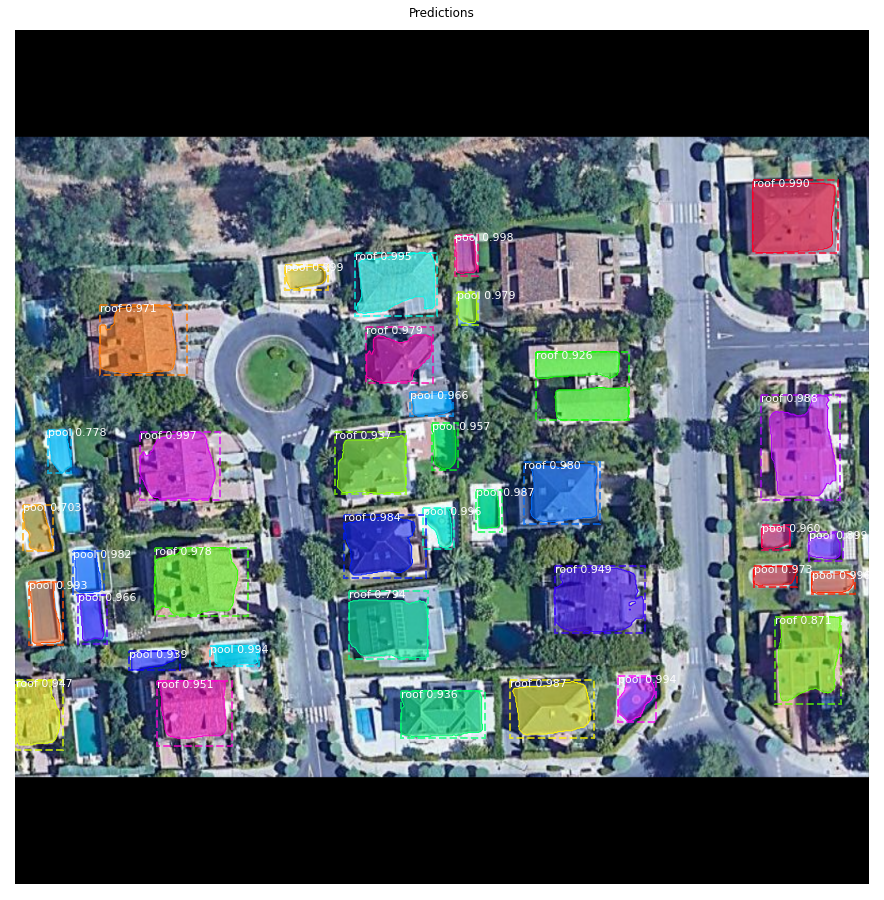

In [17]:
image_id = random.choice(val_set.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(val_set, cfg, image_id, use_mini_mask=False)
info = val_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       val_set.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            val_set.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Model evaluation

In [18]:
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = np.expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = np.mean(APs)
    return mAP

In [19]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)

# evaluate model on val dataset
val_mAP = evaluate_model(val_set, model, cfg)
print("Val mAP: %.3f" % val_mAP)

# evaluate model on test dataset
#test_mAP = evaluate_model(test_set, model, cfg)
#print("Test mAP: %.3f" % test_mAP)

Train mAP: 0.562
Val mAP: 0.469
